In [ ]:
%config Completer.use_jedi = False
%config InlineBackend.figure_formats = ['svg']

# Subclassing `sympy.Function`

In [ ]:
%pip install -q matplotlib==3.4.2 sympy==1.8

In [ ]:
from abc import abstractmethod

import sympy as sp
from helpers import (
    StateTransitionGraph,
    blatt_weisskopf,
    determine_attached_final_state,
    two_body_momentum_squared,
)

One way to address the Cons of {doc}`composition`, is to sub-class {class}`~sympy.core.function.Function`. The expression is implemented by overwriting the inherited `eval()` method and the builder is provided through the class through an additional `from_graph` class method. The interface would look like this:

In [ ]:
class DynamicsFunction(sp.Function):
    @classmethod
    @abstractmethod
    def eval(cls, *args: sp.Symbol) -> sp.Expr:
        """Implementation of the dynamics function."""

    @classmethod
    @abstractmethod
    def from_graph(cls, graph: StateTransitionGraph, edge_id: int) -> sp.Basic:
        pass

As can be seen from the implementation of a relativistic Breit-Wigner, the implementation of the expression is nicely kept together with the implementation of the expression:

In [ ]:
class RelativisticBreitWigner(DynamicsFunction):
    @classmethod
    def eval(cls, *args: sp.Symbol) -> sp.Expr:
        mass = args[0]
        mass0 = args[1]
        gamma0 = args[2]
        return (
            gamma0 * mass0 / (mass0**2 - mass**2 - gamma0 * mass0 * sp.I)
        )

    @classmethod
    def from_graph(
        cls, graph: StateTransitionGraph, edge_id: int
    ) -> "RelativisticBreitWigner":
        edge_ids = determine_attached_final_state(graph, edge_id)
        final_state_ids = map(str, edge_ids)
        mass = sp.Symbol(f"m_{{{'+'.join(final_state_ids)}}}")
        particle, _ = graph.get_edge_props(edge_id)
        mass0 = sp.Symbol(f"m_{{{particle.latex}}}")
        gamma0 = sp.Symbol(Rf"\Gamma_{{{particle.latex}}}")
        return cls(mass, mass0, gamma0)

It becomes a bit less clear when using a form factor, but the `DynamicsFunction` base class enforces a correct interfaces:

In [ ]:
class RelativisticBreitWignerWithFF(DynamicsFunction):
    @classmethod
    def eval(cls, *args: sp.Symbol) -> sp.Expr:
        # Arguments
        mass = args[0]
        mass0 = args[1]
        gamma0 = args[2]
        m_a = args[3]
        m_b = args[4]
        angular_momentum = args[5]
        meson_radius = args[6]
        # Computed variables
        q_squared = two_body_momentum_squared(mass, m_a, m_b)
        q0_squared = two_body_momentum_squared(mass0, m_a, m_b)
        ff2 = blatt_weisskopf(q_squared, meson_radius, angular_momentum)
        ff02 = blatt_weisskopf(q0_squared, meson_radius, angular_momentum)
        width = gamma0 * (mass0 / mass) * (ff2 / ff02)
        width = width * sp.sqrt(q_squared / q0_squared)
        # Expression
        return (
            RelativisticBreitWigner(mass, mass0, width)
            * mass0
            * gamma0
            * sp.sqrt(ff2)
        )

    @classmethod
    def from_graph(
        cls, graph: StateTransitionGraph, edge_id: int
    ) -> "RelativisticBreitWignerWithFF":
        edge_ids = determine_attached_final_state(graph, edge_id)
        final_state_ids = map(str, edge_ids)
        mass = sp.Symbol(f"m_{{{'+'.join(final_state_ids)}}}")
        particle, _ = graph.get_edge_props(edge_id)
        mass0 = sp.Symbol(f"m_{{{particle.latex}}}")
        gamma0 = sp.Symbol(Rf"\Gamma_{{{particle.latex}}}")
        m_a = sp.Symbol(f"m_{edge_ids[0]}")
        m_b = sp.Symbol(f"m_{edge_ids[1]}")
        angular_momentum = particle.spin  # helicity formalism only!
        meson_radius = sp.Symbol(Rf"R_{{{particle.latex}}}")
        return cls(
            mass,
            mass0,
            gamma0,
            m_a,
            m_b,
            angular_momentum,
            meson_radius,
        )

The `expression_builder` used in the syntax proposed at {ref}`adr/002:Considered solutions`, would now just be a class that is derived of `DynamicsFunction`.

The `sympy.Function` class provides mixin methods, so that the derived class behaves as a `sympy` expression. So the expression can be inspected with the usual `sympy` tools (compare the Pros of {doc}`composition`):

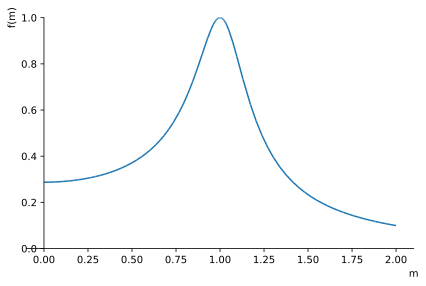

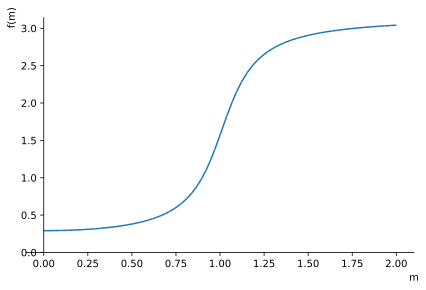

\Gamma*m_0/(-I*\Gamma*m_0 - m**2 + m_0**2)

In [ ]:
m, m0, w0 = sp.symbols(R"m m_0 \Gamma")
evaluated_bw = RelativisticBreitWigner(m, 1.0, 0.3)
sp.plot(sp.Abs(evaluated_bw), (m, 0, 2), axis_center=(0, 0), ylim=(0, 1))
sp.plot(sp.arg(evaluated_bw), (m, 0, 2), axis_center=(0, 0), ylim=(0, sp.pi))
RelativisticBreitWigner(m, m0, w0)